In [1]:
!pip install catboost
!pip install lime
!pip install streamlit
!pip install scikit-learn==1.2.2
!pip install pdpbox
!pip install mlflow
!pip install imbalanced-learn
!pip install shap
!pip install pydantic==1.10.9
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=c6574d513adccc4831acc114c1e4dcccb9ef1440eb675293b7a9a2a3fc99440e
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.5/189.5 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 107.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, fbeta_score, precision_score, recall_score, make_scorer, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from catboost import CatBoostClassifier, Pool
import tensorflow as tf
from imblearn.over_sampling import SMOTE
import lime
import lime.lime_tabular
import mlflow
import streamlit as st
import os
import shutil
import logging
import shap
import mlflow.xgboost


from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# Disable warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Check available GPUs
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# Disable logging
logging.disable(logging.WARNING)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Mounted at /content/drive
Num GPUs Available: 1


In [3]:
df = pd.read_csv('/content/drive/My Drive/projet_7/kaggle7.csv')

KeyboardInterrupt: ignored

In [ ]:
df

In [ ]:
# Séparer les colonnes catégorielles et numériques
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Maintenant, vous avez une liste des noms de colonnes catégorielles et numériques
print("Colonnes catégorielles :", categorical_columns)
print("Colonnes numériques :", numeric_columns)

In [ ]:
X = df.drop('TARGET', axis=1)
y = df['TARGET']

Dummy

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Generate sample data
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10,
                           n_clusters_per_class=2, weights=[0.1, 0.9], random_state=42)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a sub-pipeline with SMOTE and DummyClassifier
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('dummy', DummyClassifier())
])

# Define the hyperparameter grid for the sub-pipeline
param_grid = {
    'dummy__strategy': ['stratified', 'most_frequent', 'prior', 'uniform']
}

# Create an instance of GridSearchCV with the pipeline
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')

# Fit the model and evaluate
grid_search.fit(X_train, y_train)
best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_test)

# Display the classification report
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.14      0.56      0.23        25
           1       0.89      0.51      0.65       175

    accuracy                           0.52       200
   macro avg       0.52      0.54      0.44       200
weighted avg       0.80      0.52      0.60       200



Autres modèles Random Forest et XGBoost

In [ ]:


# Générer des données de démonstration
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10,
                           n_clusters_per_class=2, weights=[0.1, 0.9], random_state=42)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Définir les modèles de classificateurs que vous voulez tester
models = [
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42))
]

best_model = None
best_score = float('-inf')

for name, model in models:
    sub_pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])

    pipeline = Pipeline([
        ('sub_pipeline', sub_pipeline)
    ])

    param_grid = {}  # Ajoutez les hyperparamètres pertinents pour chaque modèle

    if name == 'Random Forest':
        param_grid['sub_pipeline__model__n_estimators'] = [100, 200, 300]
        param_grid['sub_pipeline__model__max_depth'] = [None, 10, 20]
    elif name == 'XGBoost':
        param_grid['sub_pipeline__model__n_estimators'] = [100, 200, 300]
        param_grid['sub_pipeline__model__max_depth'] = [3, 4, 5]

    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train, y_train)

    print(name)
    print("Meilleurs paramètres:", grid_search.best_params_)
    print("Meilleur score F1 avec CV:", grid_search.best_score_)

    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_model = grid_search.best_estimator_

# Évaluez le meilleur modèle sur les données de test
y_pred = best_model.predict(X_test)

# Afficher le rapport de classification
print("Meilleur modèle:", best_model.named_steps['sub_pipeline'].named_steps['model'].__class__.__name__)
print(classification_report(y_test, y_pred))


Random Forest
Meilleurs paramètres: {'sub_pipeline__model__max_depth': 20, 'sub_pipeline__model__n_estimators': 100}
Meilleur score F1 avec CV: 0.9674568798346368
XGBoost
Meilleurs paramètres: {'sub_pipeline__model__max_depth': 4, 'sub_pipeline__model__n_estimators': 100}
Meilleur score F1 avec CV: 0.9751465548748293
Meilleur modèle: XGBClassifier
              precision    recall  f1-score   support

           0       0.89      0.64      0.74        25
           1       0.95      0.99      0.97       175

    accuracy                           0.94       200
   macro avg       0.92      0.81      0.86       200
weighted avg       0.94      0.94      0.94       200



!pip uninstall mlflow pydantic scikit-learn xgboost imbalanced-learn --yes
!pip install mlflow pydantic scikit-learn xgboost imbalanced-learn


Avec suivi mlflow

In [ ]:
import mlflow
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Générer des données de démonstration
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10,
                           n_clusters_per_class=2, weights=[0.1, 0.9], random_state=42)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Définir les modèles de classificateurs que vous voulez tester
models = [
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42))
]

# Initialiser une expérience MLflow
mlflow.set_tracking_uri(f"file:///content/drive/My Drive/projet_7/mlflow")
  # Chemin vers le répertoire MLflow sur votre Google Drive

mlflow.set_experiment("Classifier Comparison")

best_model = None
best_score = float('-inf')

for name, model in models:
    sub_pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])

    pipeline = Pipeline([
        ('sub_pipeline', sub_pipeline)
    ])

    param_grid = {}  # Ajoutez les hyperparamètres pertinents pour chaque modèle

    if name == 'Random Forest':
        param_grid['sub_pipeline__model__n_estimators'] = [100, 200, 300]
        param_grid['sub_pipeline__model__max_depth'] = [None, 10, 20]
    elif name == 'XGBoost':
        param_grid['sub_pipeline__model__n_estimators'] = [100, 200, 300]
        param_grid['sub_pipeline__model__max_depth'] = [3, 4, 5]

    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train, y_train)

    # Commencer le suivi de l'exécution de l'algorithme avec MLflow
    with mlflow.start_run():
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metrics({"best_f1_score": grid_search.best_score_})

    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_model = grid_search.best_estimator_

# Commencer le suivi de l'évaluation du meilleur modèle avec MLflow
with mlflow.start_run(run_name="Best Model Evaluation") as run:  # Notice the use of 'run' here
    y_pred = best_model.predict(X_test)

    # Loguer les métriques de performance
    classification_rep = classification_report(y_test, y_pred, output_dict=True)
    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

    # Récupérer l'ID d'exécution à partir de la variable run
    run_id = run.info.run_id
    print("Run ID:", run_id)


    mlflow.log_param("best_model", best_model.named_steps['sub_pipeline'].named_steps['model'].__class__.__name__)

# Créer un répertoire pour les artefacts
    artifact_dir = '/content/drive/My Drive/mlflow_artifacts'
    os.makedirs(artifact_dir, exist_ok=True)

    # Enregistrer le meilleur modèle avec les artefacts
    mlflow.sklearn.save_model(best_model, os.path.join(artifact_dir, 'best_model'))
    mlflow.log_artifact(artifact_dir)



    # Enregistrer des artefacts - par exemple, un modèle pickle
    mlflow.sklearn.log_model(pipeline, "random_xgb")

# Fin de l'exécution de l'expérience
mlflow.end_run()


Run ID: cb16cd56d30e4a3593af4b1d39b8d89a


In [ ]:
import mlflow

# Charger l'exécution à partir de l'ID
run_id = "29cf9d1e0d5c4b1a865377b1cb17ae1c"
run = mlflow.get_run(run_id)

# Accéder aux scores
scores = run.data.metrics
print("Scores:", scores)


Scores: {'0_precision': 0.8888888888888888, '0_recall': 0.64, '0_f1-score': 0.7441860465116279, '0_support': 25.0, '1_precision': 0.9505494505494505, '1_recall': 0.9885714285714285, '1_f1-score': 0.9691876750700279, '1_support': 175.0, 'macro avg_precision': 0.9197191697191697, 'macro avg_recall': 0.8142857142857143, 'macro avg_f1-score': 0.8566868607908279, 'macro avg_support': 200.0, 'weighted avg_precision': 0.9428418803418803, 'weighted avg_recall': 0.945, 'weighted avg_f1-score': 0.9410624715002279, 'weighted avg_support': 200.0}


Cout métier

In [ ]:



# Étape 1: Créer la fonction de coût métier
def custom_cost(y_true, y_pred, beta=1):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (1 + beta**2) * tp / ((1 + beta**2) * tp + beta**2 * fn + fp)

# Divisez les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define the models you want to test
models = [
    ('Random Forest', RandomForestClassifier())
]

best_model = None
best_score = float('-inf')

for name, model in models:
    # Create a pipeline with SMOTE and the current model
    pipeline = ImbPipeline([
        ('smote', SMOTE(sampling_strategy=0.5, random_state=42)),
        ('model', model)
    ])

    scorer = make_scorer(custom_cost, greater_is_better=False, needs_proba=True, threshold=0.5)

    param_grid = {}  # Add relevant hyperparameters for each model

    if name == 'Random Forest':
        param_grid['model__n_estimators'] = [100, 200, 300]
        param_grid['model__max_depth'] = [None, 10, 20]

    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid,
                               scoring={'Cost': scorer, 'AUC': 'roc_auc', 'Accuracy': 'accuracy'},
                               refit='Cost', cv=5)
    grid_search.fit(X_train, y_train)

    print(name)
    print("Best parameters:", grid_search.best_params_)
    print("Custom cost score with CV:", -grid_search.best_score_)
    print("AUC:", grid_search.cv_results_['mean_test_AUC'][grid_search.best_index_])
    print("Accuracy:", grid_search.cv_results_['mean_test_Accuracy'][grid_search.best_index_])

    if -grid_search.best_score_ > best_score:
        best_score = -grid_search.best_score_
        best_model = grid_search.best_estimator


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 327, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
TypeError: custom_cost() got an unexpected keyword argument 'threshold'

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 327, in _score
    return self._sign * self._score_func(y, y_pred,

Random Forest
Best parameters: {'model__max_depth': None, 'model__n_estimators': 100}
Custom cost score with CV: nan
AUC: 0.9395733357279694
Accuracy: 0.9362499999999999


Avec mlflow

In [ ]:
import mlflow
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

## Étape 1: Créer la fonction de coût métier
def custom_cost(y_true, y_pred, threshold=0.5, beta=1):
    y_pred_binary = (y_pred > threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    return (1 + beta**2) * tp / ((1 + beta**2) * tp + beta**2 * fn + fp)

# Générer des données de démonstration
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10,
                           n_clusters_per_class=2, weights=[0.1, 0.9], random_state=42)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Définir les modèles de classificateurs que vous voulez tester
models = [
    ('Random Forest', RandomForestClassifier())
]

best_model = None
best_score = float('-inf')

# Initialiser une expérience MLflow
mlflow.set_tracking_uri(f"file:///content/drive/My Drive/projet_7/mlflow")
mlflow.set_experiment("score_métier")

for name, model in models:
    # Create a pipeline with SMOTE and the current model
    pipeline = ImbPipeline([
        ('smote', SMOTE(sampling_strategy=0.5, random_state=42)),
        ('model', model)
    ])

    scorer = make_scorer(custom_cost, greater_is_better=False, needs_proba=True, threshold=0.5)

    param_grid = {}  # Add relevant hyperparameters for each model

    if name == 'Random Forest':
        param_grid['model__n_estimators'] = [100, 200, 300]
        param_grid['model__max_depth'] = [None, 10, 20]

    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid,
                               scoring={'Cost': scorer, 'AUC': 'roc_auc', 'Accuracy': 'accuracy'},
                               refit='Cost', cv=5)
    grid_search.fit(X_train, y_train)

    print(name)
    print("Best parameters:", grid_search.best_params_)
    print("Custom cost score with CV:", -grid_search.best_score_)
    print("AUC:", grid_search.cv_results_['mean_test_AUC'][grid_search.best_index_])
    print("Accuracy:", grid_search.cv_results_['mean_test_Accuracy'][grid_search.best_index_])

    # Logging parameters and metrics to MLflow (corrected indentation)
    with mlflow.start_run():
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("CustomCost", -grid_search.best_score_)
        mlflow.log_metric("AUC", grid_search.cv_results_['mean_test_AUC'][grid_search.best_index_])
        mlflow.log_metric("Accuracy", grid_search.cv_results_['mean_test_Accuracy'][grid_search.best_index_])

    if -grid_search.best_score_ > best_score:
        best_score = -grid_search.best_score_
        best_model = grid_search.best_estimator_

    # Get the URI of the active run
    active_run = mlflow.active_run()

    if active_run is not None:
        run_id = active_run.info.run_id
        print("Run ID:", run_id)
    else:
        print("No active MLflow run found.")

# Log the best model if available
if best_model is not None:
    mlflow.sklearn.log_model(best_model, "best_model")
    mlflow.sklearn.log_model(pipeline, "cout_metier")

# Fin de l'exécution de l'expérience
mlflow.end_run()

Random Forest
Best parameters: {'model__max_depth': 10, 'model__n_estimators': 200}
Custom cost score with CV: 0.9656236562750882
AUC: 0.938012332375479
Accuracy: 0.93625
No active MLflow run found.


XGBOOST MEILLEUR MODELE ET FEATURE SHAP

Run ID: 4b4353dabef846f3b629d1b420afaad9


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


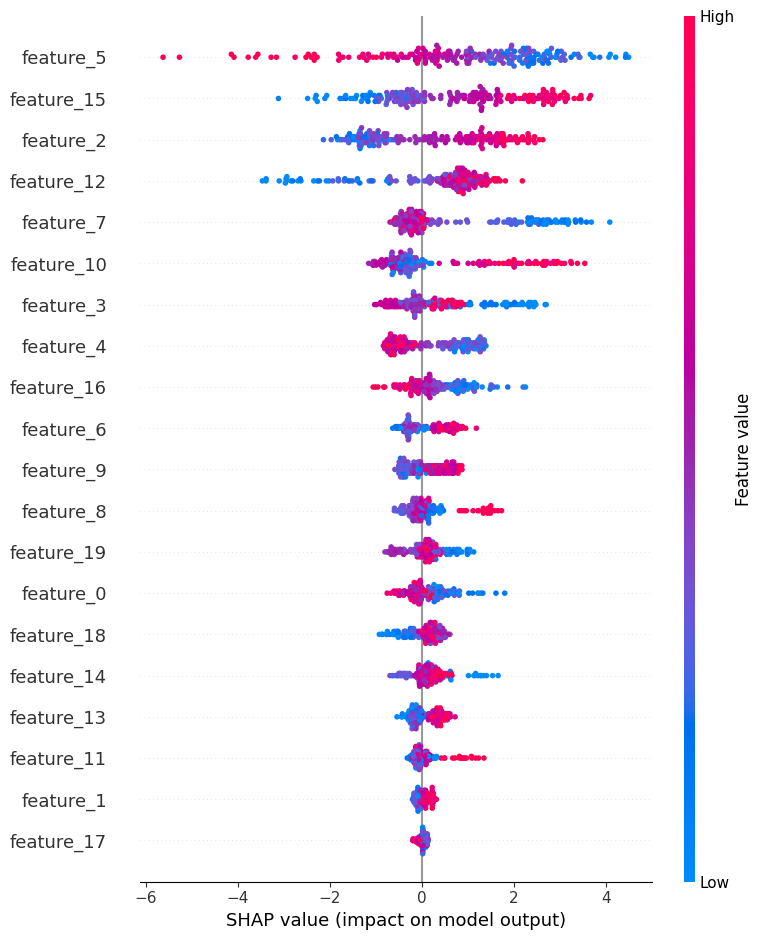

In [ ]:


# Définir l'URI de suivi MLflow et l'expérience
mlflow.set_tracking_uri(f"file:///content/drive/My Drive/projet_7/mlflow")
mlflow.set_experiment("shap")

# Créer un DataFrame pandas avec des noms de colonnes
feature_names = [f"feature_{i}" for i in range(X.shape[1])]
X_df = pd.DataFrame(X, columns=feature_names)


# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

# Définir le modèle XGBoost
xgb_model = XGBClassifier(random_state=42, n_estimators=100, max_depth=3)

# Créer une sous-pipeline avec SMOTE
sub_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', xgb_model)
])

# Créer le pipeline global
pipeline = Pipeline([
    ('sub_pipeline', sub_pipeline)
])

# Entraîner le modèle sur les données d'entraînement
pipeline.fit(X_train, y_train)

# Commencer le suivi de l'évaluation du modèle avec MLflow
with mlflow.start_run(run_name="XGBoost Model Evaluation"):
    y_pred = pipeline.predict(X_test)

    # Loguer les métriques de performance
    classification_rep = classification_report(y_test, y_pred, output_dict=True)
    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

    # Loguer le nom du modèle
    mlflow.log_param("best_model", xgb_model.__class__.__name__)
    # Enregistrer des artefacts - par exemple, un modèle pickle
    mlflow.sklearn.log_model(pipeline, "best_xgb")

    # Récupérer l'ID d'exécution
    run_id = mlflow.active_run().info.run_id
    print("Run ID:", run_id)


# Fin de l'exécution de l'expérience
mlflow.end_run()


# Calculer les valeurs SHAP pour chaque prédiction
explainer = shap.Explainer(pipeline.named_steps['sub_pipeline'].named_steps['model'])
shap_values = explainer.shap_values(X_test)

# Afficher les graphiques de résumé SHAP sans spécifier les noms des caractéristiques
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

In [ ]:
import mlflow

# Charger l'exécution à partir de l'ID
run_id = "1ba2197a3e2c45cb85efe0e93789a792"
run = mlflow.get_run(run_id)

# Accéder aux scores
scores = run.data.metrics
print("Scores:", scores)


Scores: {'0_precision': 0.7368421052631579, '0_recall': 0.56, '0_f1-score': 0.6363636363636364, '0_support': 25.0, '1_precision': 0.9392265193370166, '1_recall': 0.9714285714285714, '1_f1-score': 0.9550561797752809, '1_support': 175.0, 'macro avg_precision': 0.8380343123000873, 'macro avg_recall': 0.7657142857142858, 'macro avg_f1-score': 0.7957099080694586, 'macro avg_support': 200.0, 'weighted avg_precision': 0.9139284675777841, 'weighted avg_recall': 0.92, 'weighted avg_f1-score': 0.9152196118488253, 'weighted avg_support': 200.0}


In [ ]:
import pandas as pd
import mlflow
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report
import shap
import plotly.graph_objs as go
import plotly.offline as pyo

# Définir l'URI de suivi MLflow et l'expérience
mlflow.set_tracking_uri(f"file:///content/drive/My Drive/projet_7/mlflow")
mlflow.set_experiment("shap")

# Créer un DataFrame pandas avec des noms de colonnes
feature_names = [f"feature_{i}" for i in range(X.shape[1])]
X_df = pd.DataFrame(X, columns=feature_names)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

# Définir le modèle XGBoost
xgb_model = XGBClassifier(random_state=42, n_estimators=100, max_depth=3)

# Créer une sous-pipeline avec SMOTE
sub_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', xgb_model)
])

# Créer le pipeline global
pipeline = Pipeline([
    ('sub_pipeline', sub_pipeline)
])

# Entraîner le modèle sur les données d'entraînement
pipeline.fit(X_train, y_train)

# Commencer le suivi de l'évaluation du modèle avec MLflow
with mlflow.start_run(run_name="XGBoost Model Evaluation"):
    y_pred = pipeline.predict(X_test)

    # Loguer les métriques de performance
    classification_rep = classification_report(y_test, y_pred, output_dict=True)
    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

    # Loguer le nom du modèle
    mlflow.log_param("best_model", xgb_model.__class__.__name__)
    # Enregistrer des artefacts - par exemple, un modèle pickle
    mlflow.sklearn.log_model(pipeline, "best_xgb")

    # Récupérer l'ID d'exécution
    run_id = mlflow.active_run().info.run_id
    print("Run ID:", run_id)

# Calculer les valeurs SHAP pour chaque prédiction
explainer = shap.Explainer(pipeline.named_steps['sub_pipeline'].named_steps['model'])
shap_values = explainer.shap_values(X_test)

# Sélectionnez l'instance que vous souhaitez visualiser (par exemple, la première instance)
selected_instance = 0

# Obtenir les valeurs SHAP pour l'instance sélectionnée
shap_instance = shap_values[selected_instance]

# Obtenez les noms de colonnes pour vos fonctionnalités
feature_names = X_test.columns  # Assurez-vous que cela correspond à vos noms de colonnes

# Sélectionnez les N fonctionnalités les plus importantes
top_n = 20
top_features_idx = shap_instance.argsort()[-top_n:][::-1]
top_feature_names = feature_names[top_features_idx]
top_shap_values = shap_instance[top_features_idx]

# Créez un graphique à barres pour afficher les N fonctionnalités les plus importantes
bar_chart = go.Bar(x=top_shap_values, y=top_feature_names, orientation='h')

# Créez une mise en page de graphique
layout = go.Layout(
    title=f"Top {top_n} SHAP Values for Instance {selected_instance}",
    xaxis=dict(title="SHAP Value", automargin=True),  # Ajustez la marge automatiquement
    yaxis=dict(title="Feature", tickvals=top_feature_names, tickangle=0, automargin=True)  # Ajustez la marge automatiquement
)

# Créez la figure du graphique
fig = go.Figure(data=[bar_chart], layout=layout)

# Ajustez la taille de la figure pour éviter la troncation des noms de colonnes
fig.update_layout(height=400, width=800, margin=dict(l=100))  # Ajustez la marge gauche (l=100)

# Affichez la figure en utilisant Plotly
pyo.iplot(fig)

# Fin de l'exécution de l'expérience
mlflow.end_run()


Run ID: 5bf1ad39f32840df83309c215f2b7418
